#Material didático - Sensoriamento Remoto com Google Earth Engine - 2. Composições em falsa cor
Objetivo: Recuperação de imagem, processamento básico de valores, elaboração de composição com objetivo específico, exportação de arquivo para uso em programas SIG.

Editor: Luizemara Szameitat (contato@lszameitat.com)

>Luizemara Szameitat é bolsista CAPES - Pós-Doutorado Estratégico 2022-2024.
O presente trabalho foi realizado com apoio da Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Código de Financiamento 001.

## 1. Preparar o ambiente e solicitar dado

In [ ]:
!pip install geemap earthengine-api ipyleaflet -q

import os
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np

# GOOGLE COLAB - Adicionar chave secreta do projeto do Google Engine
from google.colab import userdata
chave_do_projeto = userdata.get('EE_PROJECT_ID')
# Autenticação no Google Cloud
from google.colab import auth
auth.authenticate_user()
# Autenticação no Earth Engine
ee.Authenticate()
# Inicializer o Earth Engine com o ID
ee.Initialize(project = chave_do_projeto )


# AREA DE INTERESSE-----------------------------------------------------------#

# Região de interesse
ponto = ee.Geometry.Point ([-45.00, -22.66])  # Primeiro longitude, depois latitude
# O valor passado para a função buffer é o raio em metros
raio = 10000  # km
area = ponto.buffer(raio).bounds()

# PRODUTO
# Catálogo EE https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1#image-properties
# dado escolhido: USGS Landsat 8 Collection 2 Tier 1 Raw Scenes.
# Bandas da coleção -> https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1#bands

# Solicito aqui para pegar a primeira imagem que atenda aos critérios
# pelo método .first()

collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
.filterBounds(area) \
    .filter(ee.Filter.lt('CLOUD_COVER', 1)) \
    .filterDate('2024-01-01','2024-07-01') \
    .sort('CLOUD_COVER') \
    .first() #pega a primeira imagem que atenda aos critérios


## 2. Escolher as bandas
Como a coleção obtida, vamos usar algumas bandas para montar uam composição em falsa cor. No exemplo, será a composição para destaque de vegetação.
- Infravermelho para Vegetação, bandas ['SR_B5', 'SR_B6', 'SR_B4'].
>  A composição tem 2 bandas do infravermelho, e a banda do vermelho no visível (infravermelho próximo, infravermelho médio e vermelho).
> - Vegetação fica em tons de laranja e vermelho, pois tem pico de  reflectância no infravermelho próximo. Tons mais escuros, vegetação mais antiga. Texturas homogêneas indicam silvicultura (mesma espécie, mesma idade).
> - A água fica entre preto e azul escuro, pois a banda do visível está na posição B. Área de plantio alagada (ex: arroz) pode aparecer azul escuro também.
> - Cidades e solo exposto entre verde claro e ciano, a depender do contraste.


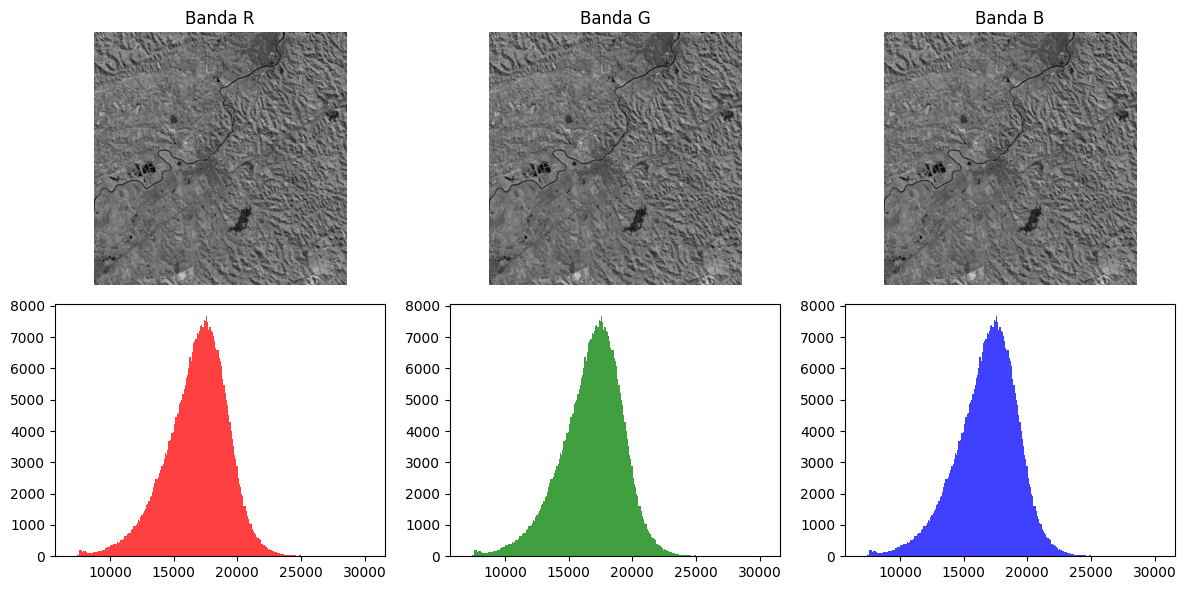

In [ ]:
# Bandas para a composição de vegetacao (NIR, SWIR, Red)
bandas = ['SR_B5', 'SR_B6', 'SR_B4']
# Selecionar as bandas na colecao
collection = collection.select(bandas)
# Cortar a area de interesse
collection = collection.clip(area)
# Selecao das bandas relevantes para essa visualizacao (RGB)
collection_RGB = collection.select(bandas)

# Plot do mapa interativo (nao é visivel quando o notebook está apenas para visualizacao no repositorio])
#Map = geemap.Map()
#Map.centerObject(area, 10)
#Map.addLayer(collection_RGB, {'bands': bandas}, 'Coleção Landsat 8')
#Map

# Plot Matplotlib
# Obter a imagem como um array NumPy
R_array = geemap.ee_to_numpy(collection.select(bandas[0]))
G_array = geemap.ee_to_numpy(collection.select(bandas[0]))
B_array = geemap.ee_to_numpy(collection.select(bandas[0]))

# Exibir a imagem usando Matplotlib com histogramas
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Imagens das bandas
axs[0, 0].imshow(R_array, cmap='gray')
axs[0, 0].set_title('Banda R')
axs[0, 0].axis('off')

axs[0, 1].imshow(G_array, cmap='gray')
axs[0, 1].set_title('Banda G')
axs[0, 1].axis('off')

axs[0, 2].imshow(B_array, cmap='gray')
axs[0, 2].set_title('Banda B')
axs[0, 2].axis('off')

# Histogramas das bandas
axs[1, 0].hist(R_array.ravel(), bins=256, color='red', alpha=0.75)
axs[1, 1].hist(G_array.ravel(), bins=256, color='green', alpha=0.75)
axs[1, 2].hist(B_array.ravel(), bins=256, color='blue', alpha=0.75)

plt.tight_layout()
plt.show()

### Tratamento do dado

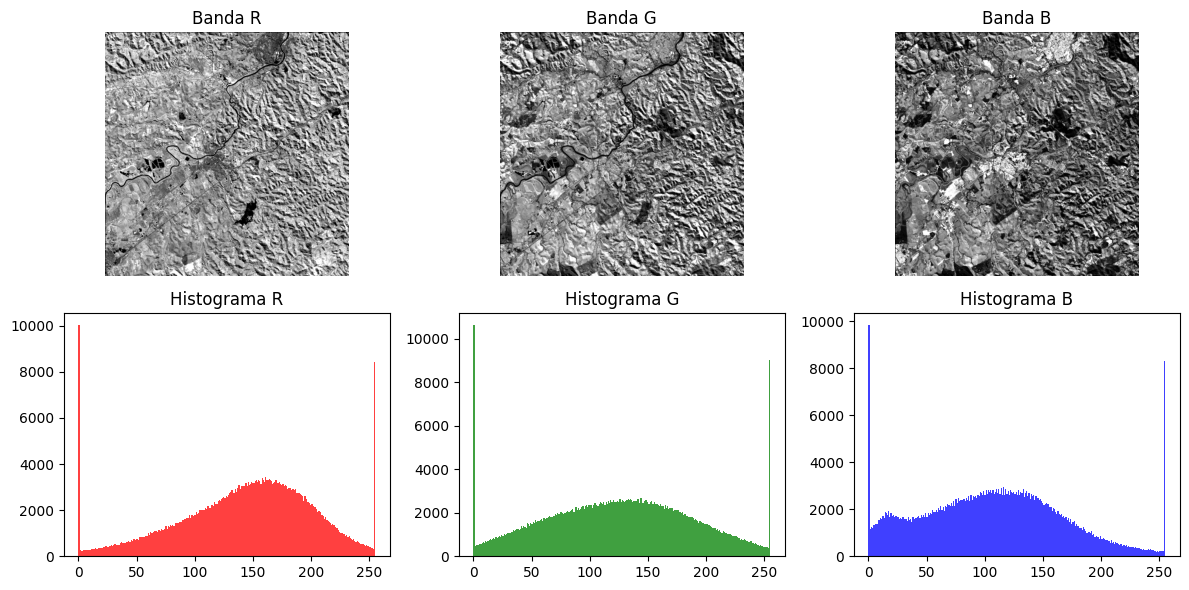

In [ ]:
def calcular_percentis(banda, data):
    percentiles = data.reduceRegion(
        reducer=ee.Reducer.percentile([2, 98]),
        geometry=area,
        scale=30,
        maxPixels=1e9
    )
    min_val = percentiles.getInfo()[f'{banda}_p2']
    max_val = percentiles.getInfo()[f'{banda}_p98']
    return min_val, max_val

# Calcular os percentis para cada banda
R_min, R_max = calcular_percentis(bandas[0], collection_RGB)
G_min, G_max = calcular_percentis(bandas[1], collection_RGB)
B_min, B_max = calcular_percentis(bandas[2], collection_RGB)

# Corrige o histograma da banda com base nos percentis
banda_R_corrigida = collection_RGB.select(bandas[0]).unitScale(R_min, R_max).clamp(0, 1)
banda_G_corrigida = collection_RGB.select(bandas[1]).unitScale(G_min, G_max).clamp(0, 1)
banda_B_corrigida = collection_RGB.select(bandas[2]).unitScale(B_min, B_max).clamp(0, 1)

# Reescala para o intervalo de 0 a 255 (tons de cinza), ou 0 a 1 a depender do uso
banda_R_corrigida = banda_R_corrigida.multiply(255).uint8()
banda_G_corrigida = banda_G_corrigida.multiply(255).uint8()
banda_B_corrigida = banda_B_corrigida.multiply(255).uint8()

# Obter a imagem como um array NumPy
R_array = geemap.ee_to_numpy(banda_R_corrigida, region=area)
G_array = geemap.ee_to_numpy(banda_G_corrigida, region=area)
B_array = geemap.ee_to_numpy(banda_B_corrigida, region=area)

# Exibir a imagem usando Matplotlib com histogramas
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Plot das bandas com Matplotlib
axs[0, 0].imshow(R_array, cmap='gray')
axs[0, 0].set_title('Banda R')
axs[0, 0].axis('off')

axs[0, 1].imshow(G_array, cmap='gray')
axs[0, 1].set_title('Banda G')
axs[0, 1].axis('off')

axs[0, 2].imshow(B_array, cmap='gray')
axs[0, 2].set_title('Banda B')
axs[0, 2].axis('off')

# Histogramas das bandas
axs[1, 0].hist(R_array.ravel(), bins=256, color='red', alpha=0.75)
axs[1, 0].set_title('Histograma R')

axs[1, 1].hist(G_array.ravel(), bins=256, color='green', alpha=0.75)
axs[1, 1].set_title('Histograma G')

axs[1, 2].hist(B_array.ravel(), bins=256, color='blue', alpha=0.75)
axs[1, 2].set_title('Histograma B')

plt.tight_layout()
plt.show()

In [ ]:
# Empilha as bandas corrigidas em uma única imagem
imagem_empilhada = banda_R_corrigida.addBands(banda_G_corrigida).addBands(banda_B_corrigida)

# Plotar a imagem no mapa interativo
Mapa = geemap.Map(center=ponto.coordinates().getInfo()[::-1], zoom=12)  # Inverta a ordem das coordenadas para o parâmetro center
Mapa.addLayer(imagem_empilhada, {'bands': bandas}, 'Equalized LANDSAT/LC08/C02/T1_L2')
Mapa

Map(center=[-22.66, -45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

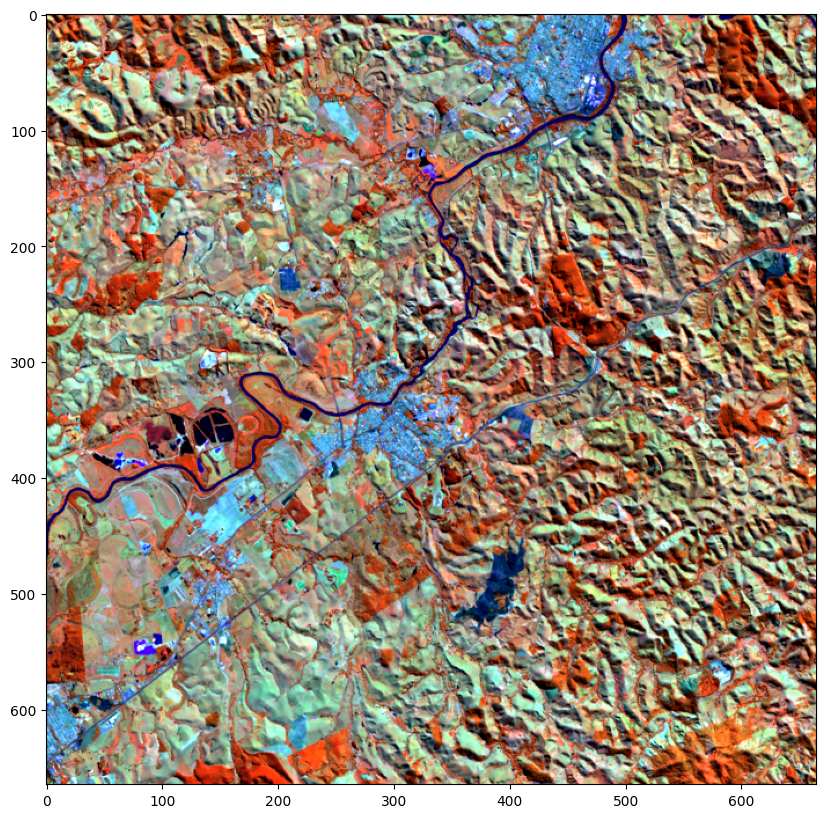

In [ ]:
# Opção 2 - Plotar pelo matplotlib
# Converter as bandas para numpy arrays
imagem_empilhada_array = geemap.ee_to_numpy(imagem_empilhada, region=area)
# Plotar
plt.figure(figsize=(16, 10))
plt.imshow(imagem_empilhada_array)
plt.show()


## Exportar o dado



In [ ]:
# A linah abaixo é opcional, caso haja erro na exportação
# PAra converter as bandas para o mesmo tipo de dados (UInt16)
# imagem_empilhada_array = imagem_empilhada_array.toUint16()

# Exportar a imagem composta para o Google Drive
# imagem_exportada = imagem_empilhada_array.clip(area)

tarefa = ee.batch.Export.image.toDrive(
    image=imagem_empilhada,
    description='CachPta_Landsat8_B5B6B4',
    folder='SensoriamentoGEE',  # Pasta do Google Drive de destino
    fileNamePrefix='CachPta_Landsat8_B5B6B4',
    region=area.getInfo()['coordinates'],
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)

# maxPixels no GEE é usado para definir o número máximo de pixels de uma imagem
# exportada. O GEE permite até 1 bilhão de pixels (1e9 pixels) em 1 exportação.

tarefa.start()
print("Exportando para o Google Drive..")


Exportando para o Google Drive..


In [ ]:
# Verifique o status das tarefas de exportação (execute até que a mensagem esteja como COMPLETED)
tasks = ee.batch.Task.list()
for task in tasks:
    print(task)

<Task 7OXCVGSW6PSDGJFICBQYRRZK EXPORT_IMAGE: CachPta_Landsat8_B5B6B4 (COMPLETED)>
<Task DNLC6LQGRISGXF74MNUMFXP4 EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task 5ZYYNBXVG56YELXTZQSBVGKW EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task SWXSQBDROY5BJEINVTYF5VJZ EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task UXD25ADALZ3SCWOG34MRRYB6 EXPORT_IMAGE: CachPta_InfravermelhoVegetacao_V2 (COMPLETED)>
<Task UUQU4VRHJXMPFBTSZP52RRVV EXPORT_IMAGE: CachPta_InfravermelhoVegetacao (COMPLETED)>
<Task AACJCL2F772DMAF2Z2PI2JSB EXPORT_IMAGE: CachPta_InfravermelhoVegetacao (COMPLETED)>
<Task Q3J5BRKL2RHTNGNI7HULBAO7 EXPORT_IMAGE: Corrected_Image_SR_B5_SR_B6_SR_B2 (COMPLETED)>
<Task D2URZGHDY4V7JVLY74SR3QMD EXPORT_IMAGE: Corrected_Image_SR_B5_SR_B4_SR_B3 (COMPLETED)>
<Task XPRCVFR7Y7KQXJTVVPDABKHX EXPORT_IMAGE: Corrected_Image_SR_B4_SR_B3_SR_B2 (COMPLETED)>
<Task PPB6JH3KSSBTVSFW3QYWS7UI EXPORT_IMAGE: CachPta_2_Landsat8_B4B3B2 (COMPLETED)>
<Task SSLNEGPJ6RABO4Z5L54VYXCH EXPORT_IMAG